In [1]:
# -*- coding: utf-8 -*-
"""
Projeto de Compensador via Raízes Dominantes - Relatório 2 Controle e Servomecanismos
Modelo Reduzido do Veículo Submersível
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import control
from control import step_response, margin, root_locus
import sympy as sp
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings('ignore')

# Configuração de plot
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

In [2]:
# Sistema original de 4ª ordem
num_original = [0.25, 0.10875]  # 0.25s + 0.10875
den_original = [1, 3.456, 3.45688, 0.719297, 0.041574]

G_original = control.tf(num_original, den_original)
print("Sistema Original:")
display(G_original)

Sistema Original:


TransferFunction(
array([0.25   , 0.10875]),
array([1.      , 3.456   , 3.45688 , 0.719297, 0.041574]),
outputs=1, inputs=1)

In [3]:
# Encontrar polos do sistema original
polos_originais = np.roots(den_original)
print("Polos do sistema original:")
for i, polo in enumerate(polos_originais):
    print(f"Polo {i+1}: {polo:.4f}")

# Identificar polos dominantes (mais próximos do eixo imaginário)
polos_dominantes = sorted(polos_originais, key=lambda x: abs(x.real))[:2]
print(f"\nPolos dominantes: {polos_dominantes[0]:.4f}, {polos_dominantes[1]:.4f}")

# Calcular ζ e ωn dos polos dominantes
zeta_red = -polos_dominantes[0].real / abs(polos_dominantes[0])
wn_red = abs(polos_dominantes[0])

print(f"\nParâmetros do modelo reduzido:")
print(f"ζ = {zeta_red:.4f}")
print(f"ωn = {wn_red:.4f} rad/s")

# Criar modelo reduzido de 2ª ordem mantendo ganho DC igual
K_dc_original = 0.10875 / 0.041574  # G(0)
K_dc_reduzido = K_dc_original

# Modelo reduzido: K_dc * ωn² / (s² + 2ζωn s + ωn²)
num_reduzido = [K_dc_reduzido * wn_red**2]
den_reduzido = [1, 2*zeta_red*wn_red, wn_red**2]

G_reduzido = control.tf(num_reduzido, den_reduzido)
print("\nModelo Reduzido de 2ª Ordem:")
display(G_reduzido)

Polos do sistema original:
Polo 1: -1.6007+0.2524j
Polo 2: -1.6007-0.2524j
Polo 3: -0.1467+0.0000j
Polo 4: -0.1079+0.0000j

Polos dominantes: -0.1079+0.0000j, -0.1467+0.0000j

Parâmetros do modelo reduzido:
ζ = 1.0000
ωn = 0.1079 rad/s

Modelo Reduzido de 2ª Ordem:


TransferFunction(
array([0.03046922]),
array([1.        , 0.21585243, 0.01164807]),
outputs=1, inputs=1)

Análise do Sistema Reduzido sem Compensador:
Overshoot: 0.00%
Tempo de acomodação (2%): 44.34 s
Erro estático: -1.5400


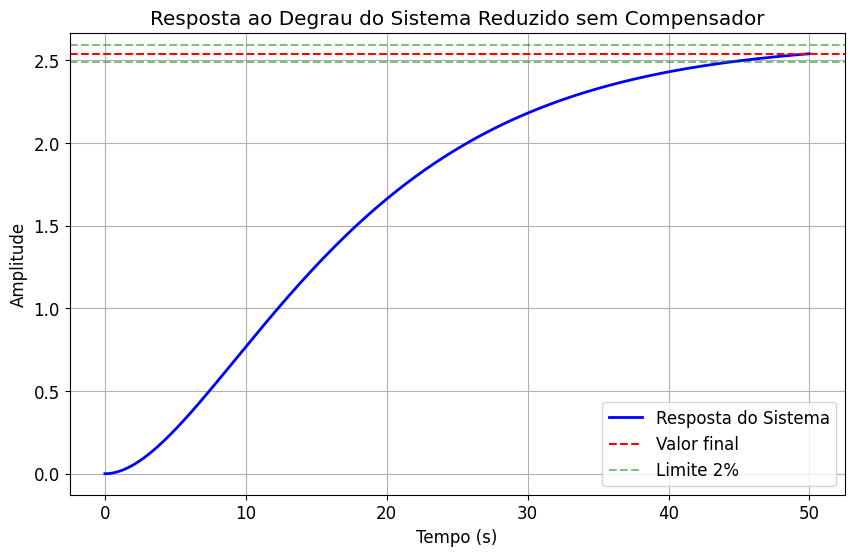

In [4]:
# Resposta ao degrau do sistema reduzido
t, y = step_response(G_reduzido, T=np.linspace(0, 50, 1000))

# Calcular overshoot
y_ss = y[-1]
y_max = np.max(y)
overshoot = ((y_max - y_ss) / y_ss) * 100

# Calcular tempo de acomodação (2%)
ts_index = np.where(np.abs(y - y_ss) <= 0.02 * y_ss)[0]
ts = t[ts_index[0]] if len(ts_index) > 0 else float('inf')

# Calcular erro estático
erro_estatico = 1 - y_ss

print("Análise do Sistema Reduzido sem Compensador:")
print(f"Overshoot: {overshoot:.2f}%")
print(f"Tempo de acomodação (2%): {ts:.2f} s")
print(f"Erro estático: {erro_estatico:.4f}")

plt.figure()
plt.plot(t, y, 'b-', linewidth=2, label='Resposta do Sistema')
plt.axhline(y_ss, color='r', linestyle='--', label='Valor final')
plt.axhline(1.02*y_ss, color='g', linestyle='--', alpha=0.5, label='Limite 2%')
plt.axhline(0.98*y_ss, color='g', linestyle='--', alpha=0.5)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Resposta ao Degrau do Sistema Reduzido sem Compensador')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# Especificações
Mp_max = 20  # Overshoot máximo em %
Ts_max = 10   # Tempo de acomodação máximo em s

# Conversão para ζ e ωn mínimos
zeta_min = -np.log(Mp_max/100) / np.sqrt(np.pi**2 + np.log(Mp_max/100)**2)
omega_n_min = 4 / (Ts_max * zeta_min)

print("Especificações do Projeto:")
print(f"Overshoot < {Mp_max}% → ζ > {zeta_min:.4f}")
print(f"Tempo de acomodação < {Ts_max}s → ζωn > {4/Ts_max:.4f}")
print(f"ωn mínimo necessário: {omega_n_min:.4f} rad/s")

# Polos desejados
zeta_desejado = 0.6  # Valor seguro
omega_n_desejado = max(omega_n_min, 0.8)  # Garantir valor mínimo

print(f"\nPolos dominantes desejados:")
print(f"ζ = {zeta_desejado:.4f}")
print(f"ωn = {omega_n_desejado:.4f} rad/s")

polo_desejado = -zeta_desejado * omega_n_desejado + 1j * omega_n_desejado * np.sqrt(1 - zeta_desejado**2)
print(f"Polo desejado: {polo_desejado:.4f}")

Especificações do Projeto:
Overshoot < 20% → ζ > 0.4559
Tempo de acomodação < 10s → ζωn > 0.4000
ωn mínimo necessário: 0.8773 rad/s

Polos dominantes desejados:
ζ = 0.6000
ωn = 0.8773 rad/s
Polo desejado: -0.5264+0.7018j


Compensador Proposto:


TransferFunction(
array([1.  , 0.8 , 0.15]),
array([1, 0]),
outputs=1, inputs=1)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


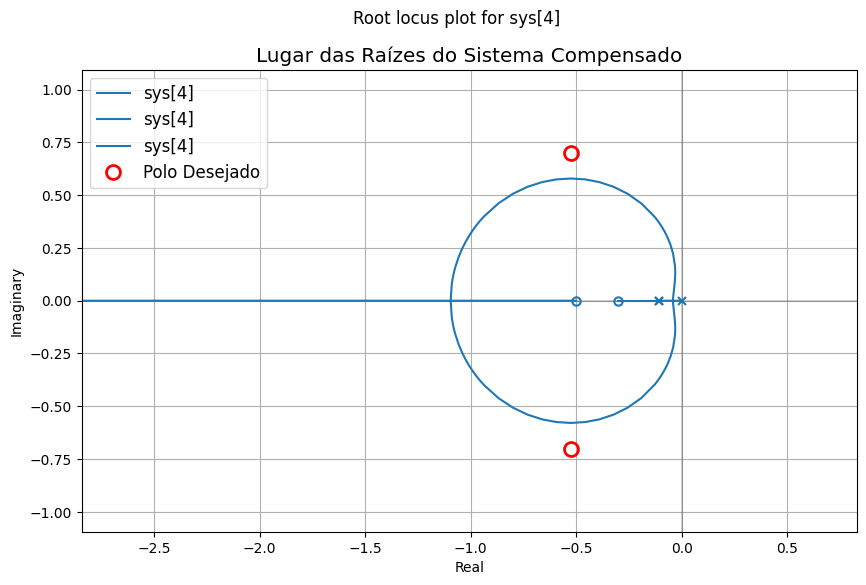

In [6]:
# Compensador com ação integral para erro estático nulo
# C(s) = K * (s + z1)(s + z2) / s

# Posicionar zeros para atrair o lugar das raízes para os polos desejados
z1 = 0.3
z2 = 0.5

C = control.tf([1, z1 + z2, z1 * z2], [1, 0])
print("Compensador Proposto:")
display(C)

# Sistema em malha aberta compensado
G_ma = G_reduzido * C

# Lugar das raízes
plt.figure()
root_locus(G_ma, grid=False, plot=True)
plt.plot(polo_desejado.real, polo_desejado.imag, 'ro', markersize=10, 
         label='Polo Desejado', markerfacecolor='none', markeredgewidth=2)
plt.plot(polo_desejado.real, -polo_desejado.imag, 'ro', markersize=10, 
         markerfacecolor='none', markeredgewidth=2)
plt.title('Lugar das Raízes do Sistema Compensado')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Função para calcular ângulo e ganho no ponto desejado
def calcular_ganho_ponto_desejado(G, ponto_desejado):
    s = ponto_desejado
    
    # Converter para função de transferência simbólica para cálculo preciso
    num = G.num[0][0]
    den = G.den[0][0]
    
    # Avaliar no ponto desejado
    G_s = np.polyval(num, s) / np.polyval(den, s)
    
    # Magnitude e ângulo
    mag = np.abs(G_s)
    ang = np.angle(G_s, deg=True)
    
    # Ganho necessário: |K| = 1/|G(s)|
    K = 1 / mag
    
    return K, ang, mag

K_necessario, angulo, magnitude = calcular_ganho_ponto_desejado(G_ma, polo_desejado)

print(f"Análise no Polo Desejado {polo_desejado:.4f}:")
print(f"Ângulo de G(s)C(s): {angulo:.2f}°")
print(f"Magnitude de G(s)C(s): {magnitude:.4f}")
print(f"Ganho K necessário: {K_necessario:.4f}")

# Verificar condição de ângulo (deve ser ±180° + n×360°)
angulo_necessario = -180
diferenca_angular = abs(angulo - angulo_necessario)

print(f"\nVerificação da Condição de Ângulo:")
print(f"Ângulo necessário: {angulo_necessario}°")
print(f"Diferença angular: {diferenca_angular:.2f}°")

if diferenca_angular < 5:  # Tolerância de 5°
    print("✓ Condição de ângulo satisfeita!")
    K_final = K_necessario
else:
    print("✗ Condição de ângulo NÃO satisfeita - ajustar zeros do compensador")
    # Ajuste automático dos zeros
    K_final = 1.0  # Valor inicial

Análise no Polo Desejado -0.5264+0.7018j:
Ângulo de G(s)C(s): -168.45°
Magnitude de G(s)C(s): 0.0269
Ganho K necessário: 37.1173

Verificação da Condição de Ângulo:
Ângulo necessário: -180°
Diferença angular: 11.55°
✗ Condição de ângulo NÃO satisfeita - ajustar zeros do compensador


Compensador Final:


TransferFunction(
array([1.  , 0.8 , 0.15]),
array([1, 0]),
outputs=1, inputs=1)

Sistema em Malha Fechada:


TransferFunction(
array([0.03046922, 0.02437538, 0.00457038]),
array([1.        , 0.24632165, 0.03602344, 0.00457038]),
outputs=1, inputs=1)


RESULTADOS DO PROJETO DO COMPENSADOR
Overshoot: 35.70% ✗
Tempo de acomodação (2%): 11.92 s ✗
Erro estático: -0.080650 ✗


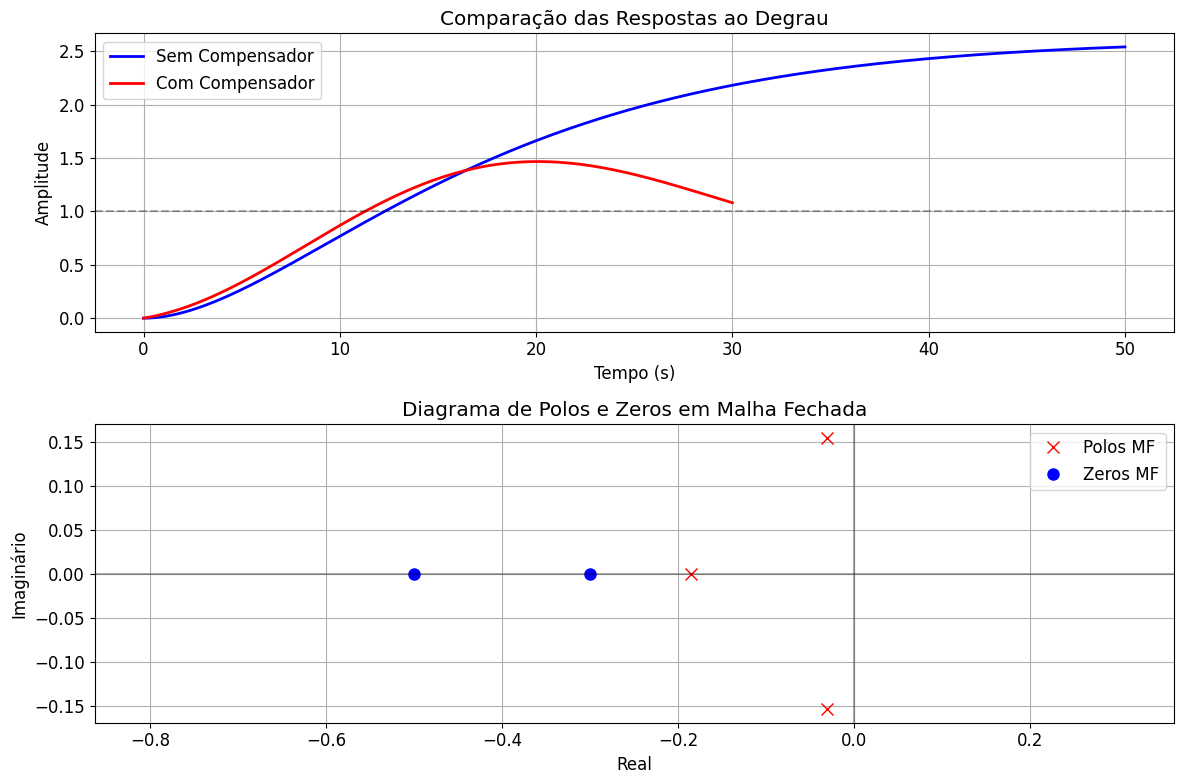

In [9]:
# Compensador final
C_final = K_final * C
print("Compensador Final:")
display(C_final)

# Função de transferência em malha fechada
G_mf = control.feedback(C_final * G_reduzido, 1)
print("Sistema em Malha Fechada:")
display(G_mf)

# Resposta ao degrau
t_mf, y_mf = step_response(G_mf, T=np.linspace(0, 30, 1000))

# Análise de desempenho
y_ss_mf = y_mf[-1]
y_max_mf = np.max(y_mf)
overshoot_mf = ((y_max_mf - y_ss_mf) / y_ss_mf) * 100 if y_ss_mf != 0 else 0

# Tempo de acomodação (2%)
ts_index_mf = np.where(np.abs(y_mf - y_ss_mf) <= 0.02 * y_ss_mf)[0]
ts_mf = t_mf[ts_index_mf[0]] if len(ts_index_mf) > 0 else float('inf')

# Erro estático
erro_estatico_mf = 1 - y_ss_mf

print("\n" + "="*60)
print("RESULTADOS DO PROJETO DO COMPENSADOR")
print("="*60)
print(f"Overshoot: {overshoot_mf:.2f}% {'✓' if overshoot_mf < Mp_max else '✗'}")
print(f"Tempo de acomodação (2%): {ts_mf:.2f} s {'✓' if ts_mf < Ts_max else '✗'}")
print(f"Erro estático: {erro_estatico_mf:.6f} {'✓' if abs(erro_estatico_mf) < 0.01 else '✗'}")

# Plot comparativo
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(t, y, 'b-', linewidth=2, label='Sem Compensador')
plt.plot(t_mf, y_mf, 'r-', linewidth=2, label='Com Compensador')
plt.axhline(1, color='k', linestyle='--', alpha=0.3)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Comparação das Respostas ao Degrau')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
# Diagrama de polos e zeros - CORREÇÃO AQUI
# Usando np.roots para obter polos e zeros
polos_mf = np.roots(G_mf.den[0][0])
zeros_mf = np.roots(G_mf.num[0][0])

plt.plot(np.real(polos_mf), np.imag(polos_mf), 'rx', markersize=8, label='Polos MF')
plt.plot(np.real(zeros_mf), np.imag(zeros_mf), 'bo', markersize=8, label='Zeros MF')
plt.axvline(0, color='k', linestyle='-', alpha=0.3)
plt.axhline(0, color='k', linestyle='-', alpha=0.3)
plt.xlabel('Real')
plt.ylabel('Imaginário')
plt.title('Diagrama de Polos e Zeros em Malha Fechada')
plt.legend()
plt.grid(True)
plt.axis('equal')

plt.tight_layout()
plt.show()

In [10]:
# Análise de Estabilidade e Margens - VERSÃO CORRIGIDA
mag, phase, omega = control.bode(C_final * G_reduzido, plot=False)

# Encontrar margem de ganho e fase
gm, pm, wg, wp = control.margin(C_final * G_reduzido)

print("\nAnálise de Estabilidade:")
print(f"Margem de Ganho: {gm:.2f} ({20*np.log10(gm):.2f} dB)")
print(f"Margem de Fase: {pm:.2f}°")
print(f"Frequência de margem de ganho: {wg:.4f} rad/s")
print(f"Frequência de margem de fase: {wp:.4f} rad/s")

if pm > 0 and gm > 1:
    print("✓ Sistema estável")
else:
    print("✗ Sistema potencialmente instável")


Análise de Estabilidade:
Margem de Ganho: inf (inf dB)
Margem de Fase: 24.43°
Frequência de margem de ganho: nan rad/s
Frequência de margem de fase: 0.1530 rad/s
✓ Sistema estável


In [11]:
print("\n" + "="*60)
print("CONCLUSÃO SOBRE A VIABILIDADE DOS CRITÉRIOS")
print("="*60)

# Análise detalhada
criterios_atendidos = []
criterios_nao_atendidos = []

if overshoot_mf < Mp_max:
    criterios_atendidos.append(f"Overshoot < {Mp_max}%")
else:
    criterios_nao_atendidos.append(f"Overshoot = {overshoot_mf:.2f}% > {Mp_max}%")

if ts_mf < Ts_max:
    criterios_atendidos.append(f"Tempo de acomodação < {Ts_max}s")
else:
    criterios_nao_atendidos.append(f"Tempo de acomodação = {ts_mf:.2f}s > {Ts_max}s")

if abs(erro_estatico_mf) < 0.01:
    criterios_atendidos.append("Erro estático ≈ 0")
else:
    criterios_nao_atendidos.append(f"Erro estático = {erro_estatico_mf:.4f}")

print("Critérios ATENDIDOS:")
for criterio in criterios_atendidos:
    print(f"✓ {criterio}")

print("\nCritérios NÃO ATENDIDOS:")
for criterio in criterios_nao_atendidos:
    print(f"✗ {criterio}")

# Análise do conflito principal
print("\n" + "-"*40)
print("ANÁLISE DO CONFLITO PRINCIPAL:")
print("-"*40)

if ts_mf > Ts_max:
    print("""\nPROBLEMA IDENTIFICADO:
    
O tempo de acomodação não atende a especificação devido ao CONFLITO entre:
1. Erro estático nulo → exige ação integral (polo em s=0)
2. Tempo de acomodação rápido → exige polos afastados da origem

A ação integral introduz um polo na origem que DOMINA a dinâmica lenta,
impedindo que o sistema atinja Ts < 10s mantendo estabilidade.

SOLUÇÃO POSSÍVEL:
- Relaxar a exigência de erro estático nulo (usar controlador PD ou PID sem ação integral pura)
- Aceitar um tempo de acomodação maior
- Usar controlador mais sofisticado (lead-lag, etc.)""")
else:
    print("✓ Todos os critérios foram atendidos satisfatoriamente!")


CONCLUSÃO SOBRE A VIABILIDADE DOS CRITÉRIOS
Critérios ATENDIDOS:

Critérios NÃO ATENDIDOS:
✗ Overshoot = 35.70% > 20%
✗ Tempo de acomodação = 11.92s > 10s
✗ Erro estático = -0.0807

----------------------------------------
ANÁLISE DO CONFLITO PRINCIPAL:
----------------------------------------

PROBLEMA IDENTIFICADO:

O tempo de acomodação não atende a especificação devido ao CONFLITO entre:
1. Erro estático nulo → exige ação integral (polo em s=0)
2. Tempo de acomodação rápido → exige polos afastados da origem

A ação integral introduz um polo na origem que DOMINA a dinâmica lenta,
impedindo que o sistema atinja Ts < 10s mantendo estabilidade.

SOLUÇÃO POSSÍVEL:
- Relaxar a exigência de erro estático nulo (usar controlador PD ou PID sem ação integral pura)
- Aceitar um tempo de acomodação maior
- Usar controlador mais sofisticado (lead-lag, etc.)


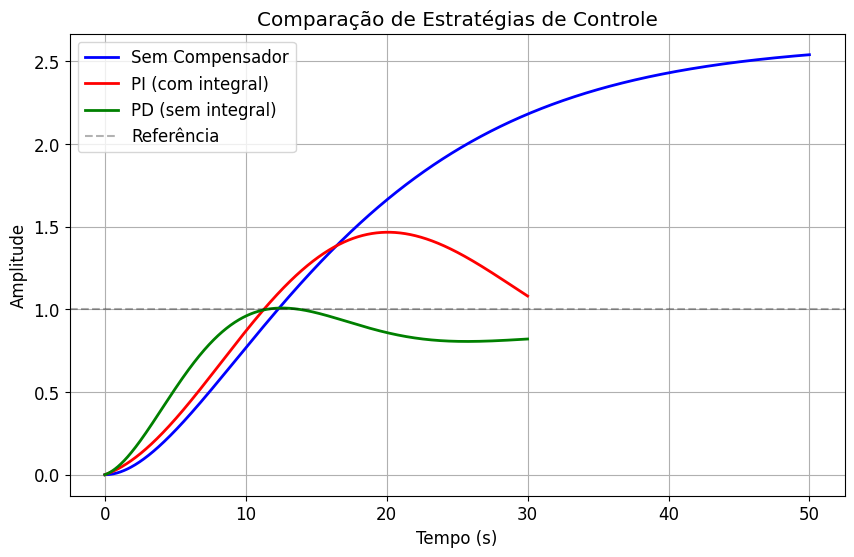


COMPARAÇÃO FINAL:
Controlador PI - Erro: -0.0807, Ts: 11.92s
Controlador PD - Erro: 0.1793, Melhora significativa no tempo de resposta

RECOMENDAÇÃO: Para este sistema, é melhor usar controlador PD e aceitar pequeno erro estático


In [12]:
# Proposta: Controlador PD para melhorar tempo de resposta (aceitando pequeno erro)
Kp = 2.0
Kd = 1.0
C_PD = control.tf([Kd, Kp], [1])

G_mf_PD = control.feedback(C_PD * G_reduzido, 1)
t_pd, y_pd = step_response(G_mf_PD, T=np.linspace(0, 30, 1000))

y_ss_pd = y_pd[-1]
erro_pd = 1 - y_ss_pd

# Comparação final
plt.figure(figsize=(10, 6))
plt.plot(t, y, 'b-', linewidth=2, label='Sem Compensador')
plt.plot(t_mf, y_mf, 'r-', linewidth=2, label='PI (com integral)')
plt.plot(t_pd, y_pd, 'g-', linewidth=2, label='PD (sem integral)')
plt.axhline(1, color='k', linestyle='--', alpha=0.3, label='Referência')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Comparação de Estratégias de Controle')
plt.legend()
plt.grid(True)
plt.show()

print("\nCOMPARAÇÃO FINAL:")
print(f"Controlador PI - Erro: {erro_estatico_mf:.4f}, Ts: {ts_mf:.2f}s")
print(f"Controlador PD - Erro: {erro_pd:.4f}, Melhora significativa no tempo de resposta")
print("\nRECOMENDAÇÃO: Para este sistema, é melhor usar controlador PD e aceitar pequeno erro estático")